In [57]:
# define an lstm network using pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns

In [58]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [59]:
class GeometricNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=8, output_size=1, dropout=0.6):
        super(GeometricNet, self).__init__()
        self.dropout = dropout
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.Dropout(dropout),
            nn.ReLU(),
        )
        self.fc1 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc2 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc3 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc4 = nn.Linear(hidden_size, hidden_size, bias=False)
        self.fc5 = nn.Linear(hidden_size, output_size, bias=False)

    def forward(self, x):
        x0, x1 = x
        x0 = self.mlp(x0)
        x1 = self.mlp(x1)
        x = x0 - x1
        x = torch.tanh(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = torch.tanh(self.fc2(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = torch.tanh(self.fc3(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = torch.tanh(self.fc4(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = torch.tanh(self.fc5(x))
        return x

In [60]:
class SimpleNet(nn.Module):
    def __init__(self, input_size=1, hidden_size=8, output_size=1, hidden_layers=4):
        super(SimpleNet, self).__init__()
        
        self.input_layer = nn.Linear(2*input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(hidden_layers)])
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x0, x1 = x
        x = torch.cat([x0, x1], dim=1)
        x = F.relu(self.input_layer(x))
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        x = self.output_layer(x)
        x = torch.tanh(x)
        return x

In [61]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GINConv, global_mean_pool


class CatNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.6, hidden_size=8, n_nodes=5, emb_dim=64):
        super(CatNet, self).__init__()
        self.dropout = dropout
        self.emb = nn.Parameter(torch.randn(n_nodes, 1, emb_dim))
        self.lstm = nn.LSTM(
            input_size=in_channels, hidden_size=hidden_size, num_layers=3, batch_first=True, dropout=dropout)

        self.conv1 = SAGEConv(hidden_size, hidden_size)
        self.conv2 = SAGEConv(hidden_size, hidden_size)
        self.conv3 = SAGEConv(hidden_size, hidden_size)
        self.geo = GeometricNet(
            input_size=hidden_size, hidden_size=hidden_size, output_size=out_channels, dropout=dropout)

    def forward(self, edge_index, hidden, i, j):
        out = []
        new_hidden = []
        for x_i, hidden_i in zip(self.emb, hidden):
            hidden_i = (hidden_i[0], hidden_i[1])
            x_i, hidden_i = self.lstm(x_i.unsqueeze(0), hidden_i)
            out.append(x_i)
            new_hidden.append(hidden_i)
        x = torch.cat(out, dim=0)
        hidden = new_hidden
        x = x.squeeze(1)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        a, b = x[i], x[j]
        x = self.geo((a, b))
        return x, hidden


In [62]:
# load all csv files in data folder
import os
import pandas as pd
import numpy as np

def load_data(path):
    data = {}
    names = ['time', 'open', 'high', 'low', 'close', 'volume']
    for file in os.listdir(path):
        if file.endswith('.csv'):
            pair = file[10:16].lower()
            df = pd.read_csv(os.path.join(path, file), names=names, sep=';')
            df = df[['time', 'close']]
            df.columns = ['time', pair]
            data[pair] = df
    return data

data = load_data('data')

In [63]:
# pandas inner join all dataframes
keys = sorted(data.keys())
df = data[keys[0]]
for pair in keys[1:]:
    df = df.merge(data[pair], on='time')

# drop time column
df = df.drop('time', axis=1)

df.head()

,cadchf,eurcad,eurchf,eurgbp,eurusd,gbpcad,gbpchf,gbpusd,usdcad,usdchf
0,0.71979,1.43634,1.03569,0.84034,1.13733,1.70793,1.23261,1.35266,1.26296,0.91112
1,0.71980,1.43604,1.03532,0.84034,1.13733,1.70793,1.23263,1.35265,1.26297,0.91107
2,0.71980,1.43655,1.03522,0.84030,1.13730,1.70860,1.23183,1.35285,1.26296,0.91015
3,0.72056,1.43711,1.03668,0.84036,1.13750,1.70913,1.23358,1.35307,1.26350,0.91180
4,0.72124,1.43667,1.03691,0.84044,1.13766,1.70897,1.23367,1.35321,1.26299,0.91162


In [64]:
currencies = ['cad', 'chf', 'eur', 'gbp', 'usd']

In [65]:
# preprocess data

# log exchange rates
df = np.log(df)

# calculate change in exchange rates
df = df.diff().drop(0, axis=0)

df.head()




,cadchf,eurcad,eurchf,eurgbp,eurusd,gbpcad,gbpchf,gbpusd,usdcad,usdchf
1,0.000014,-0.000209,-0.000357,0.000000,0.000000,0.000000,0.000016,-0.000007,0.000008,-0.000055
2,0.000000,0.000355,-0.000097,-0.000048,-0.000026,0.000392,-0.000649,0.000148,-0.000008,-0.001010
3,0.001055,0.000390,0.001409,0.000071,0.000176,0.000310,0.001420,0.000163,0.000427,0.001811
4,0.000943,-0.000306,0.000222,0.000095,0.000141,-0.000094,0.000073,0.000103,-0.000404,-0.000197
5,0.000527,0.000306,0.000386,0.000238,0.000026,0.000146,0.000057,-0.000052,0.000166,0.000143


In [66]:
# train test split
train_size = 15
test_size = 5
train_df = df[:train_size]
test_df = df[:train_size + test_size]

In [67]:
abs_max = train_df.abs().max()
abs_max

cadchf    0.001055
eurcad    0.000390
eurchf    0.001409
eurgbp    0.000238
eurusd    0.000316
gbpcad    0.000392
gbpchf    0.001420
gbpusd    0.000251
usdcad    0.000427
usdchf    0.001811
dtype: float64

In [68]:
# normalize data
train_df = train_df / abs_max
test_df = test_df / abs_max

train_df.head()

,cadchf,eurcad,eurchf,eurgbp,eurusd,gbpcad,gbpchf,gbpusd,usdcad,usdchf
1,0.013165,-0.535953,-0.253534,0.000000,0.000000,0.000000,0.011429,-0.029417,0.018522,-0.030299
2,0.000000,0.911054,-0.068538,-0.200052,-0.083343,1.000000,-0.457319,0.588301,-0.018522,-0.557799
3,1.000000,1.000000,1.000000,0.300075,0.555580,0.790767,1.000000,0.647030,1.000000,1.000000
4,0.893843,-0.785681,0.157406,0.400067,0.444394,-0.238696,0.051390,0.411692,-0.944433,-0.109003
5,0.499134,0.785681,0.273666,1.000000,0.083317,0.372953,0.039968,-0.205841,0.388930,0.078726


In [82]:
# define train and test functions
def train(model, optimizer, train_df, edge_index, pair_inidices, hidden_0, n_epochs=100):
    loss_func = nn.MSELoss()
    model.train()
    losses = []
    for epoch in range(n_epochs):
        hidden = hidden_0
        train_data = torch.tensor(train_df.values, dtype=torch.float).to(device)
        total_loss = 0
        for t in range(train_data.shape[0]):
            optimizer.zero_grad()
            y_hat, hidden = model(edge_index, hidden, pair_inidices[0], pair_inidices[1])
            hidden = tuple([(each[0].data, each[1].data) for each in hidden])
            y = train_data[t].view(-1, 1).to(device)
            loss = loss_func(y_hat, y)
            total_loss += loss.item()
            loss.backward(retain_graph=True)
            optimizer.step()

        losses.append(total_loss / train_data.shape[0])
        print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, total_loss / train_data.shape[0]))
    return losses
            

In [70]:
n_nodes = len(currencies)
edge_index = torch.tensor([[i, j] for i in range(n_nodes) for j in range(n_nodes)], dtype=torch.long).t().contiguous().to(device)

In [71]:
pair_inidices = [(currencies.index(pair[:3]), currencies.index(pair[3:])) for pair in df.columns]
pair_inidices = torch.tensor(pair_inidices, dtype=torch.long).t().contiguous()

In [72]:
emb_dim = 32
n_nodes = len(currencies)
hidden = tuple([(torch.randn(3, 1, emb_dim).to(device), torch.randn(3, 1, emb_dim).to(device)) for _ in range(n_nodes)])

In [83]:
torch.set_grad_enabled(True)
torch.autograd.set_detect_anomaly(True)
model = CatNet(in_channels=emb_dim, out_channels=1, dropout=0, hidden_size=emb_dim, emb_dim=emb_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = train(model, optimizer, train_df, edge_index, pair_inidices, hidden, n_epochs=1000)

Epoch: 000, Loss: 0.16450
Epoch: 001, Loss: 0.16450
Epoch: 002, Loss: 0.16450
Epoch: 003, Loss: 0.16447
Epoch: 004, Loss: 0.16406
Epoch: 005, Loss: 0.16128
Epoch: 006, Loss: 0.15901
Epoch: 007, Loss: 0.15413
Epoch: 008, Loss: 0.16118
Epoch: 009, Loss: 0.14913
Epoch: 010, Loss: 0.14820
Epoch: 011, Loss: 0.14003
Epoch: 012, Loss: 0.14088
Epoch: 013, Loss: 0.13454
Epoch: 014, Loss: 0.13304
Epoch: 015, Loss: 0.12618
Epoch: 016, Loss: 0.12745
Epoch: 017, Loss: 0.12735
Epoch: 018, Loss: 0.12646
Epoch: 019, Loss: 0.12625
Epoch: 020, Loss: 0.12432
Epoch: 021, Loss: 0.13169
Epoch: 022, Loss: 0.12819
Epoch: 023, Loss: 0.12296
Epoch: 024, Loss: 0.12050
Epoch: 025, Loss: 0.12348
Epoch: 026, Loss: 0.11585
Epoch: 027, Loss: 0.11471
Epoch: 028, Loss: 0.11887
Epoch: 029, Loss: 0.12867
Epoch: 030, Loss: 0.11942
Epoch: 031, Loss: 0.11100
Epoch: 032, Loss: 0.11350
Epoch: 033, Loss: 0.11820
Epoch: 034, Loss: 0.12317
Epoch: 035, Loss: 0.11718
Epoch: 036, Loss: 0.10730
Epoch: 037, Loss: 0.11995
Epoch: 038, 

In [84]:
# test model
def test(model, test_df, edge_index, pair_inidices, hidden_0):
    model.eval()
    test_data = torch.tensor(test_df.values, dtype=torch.float).to(device)
    hidden = hidden_0
    y_hat = []
    for t in range(test_data.shape[0]):
        y_hat_t, hidden = model(edge_index, hidden, pair_inidices[0], pair_inidices[1])
        hidden = tuple([(each[0].data, each[1].data) for each in hidden])
        y_hat.append(y_hat_t)
    return torch.stack(y_hat)

y_hat = test(model, train_df, edge_index, pair_inidices, hidden)



In [85]:
# compute mean squared error
y_hat = test(model, test_df, edge_index, pair_inidices, hidden)
mse_func = nn.MSELoss()
mse = mse_func(y_hat.squeeze(-1), torch.tensor(test_df.values, dtype=torch.float).to(device))

mse

tensor(0.0480, device='cuda:0', grad_fn=<MseLossBackward0>)

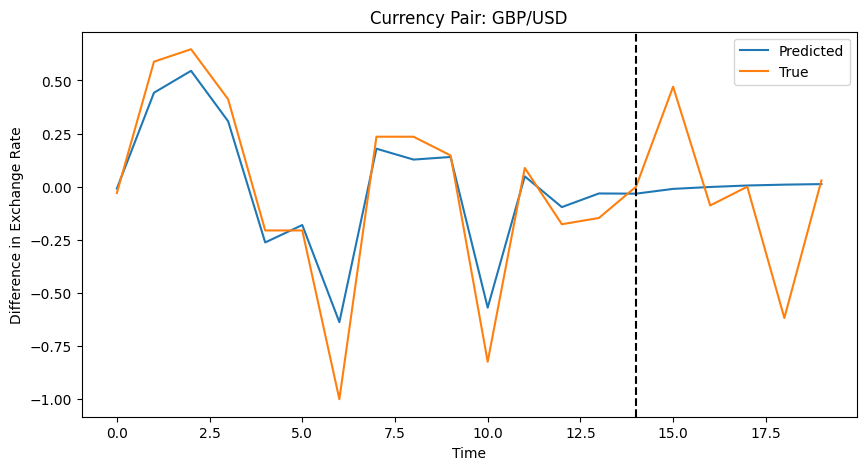

In [97]:
# plot first currency pair
import matplotlib.pyplot as plt

currency_pair = 7

plt.figure(figsize=(10, 5))
plt.plot(y_hat[:, currency_pair].cpu().detach().numpy(), label='Predicted')
plt.plot(test_df.values[:, currency_pair], label='True')
# draw vertical line to separate train and test data
plt.axvline(x=train_size-1, color='black', linestyle='--')
plt.title('Currency Pair: {}'.format(df.columns[currency_pair][:3].upper() + '/' + df.columns[currency_pair][3:].upper()))
plt.xlabel('Time')
plt.ylabel('Difference in Exchange Rate')
plt.legend()
plt.show()
